# Clustering Crypto

In [3]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Amazon SageMaker and related imports
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3  # AWS Python sdk
import altair as alt

## Reading the Data file created from clustering exercise 

In [77]:

# Read the coin data into Amazon Cloud Storage
file_path = Path("Resources/X.pkl")
features = pd.read_pickle(file_path)

# Transforming the "TempAvgF" column to a vector
X = features["TempAvgF"].values.reshape(-1, 1)
# Read the target data (precipitation sum inches)
file_path = Path("Data/y_austin_final.csv")
y = pd.read_csv(file_path, names=["PrecipitationSumInches"], header=None)

# Transforming y into a vector
y = y.iloc[:, 0].values
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)e provided csv file:


In [87]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df)
X.head()

,Algorithm_Autolykos,Algorithm_BEP-2,Algorithm_BEP-20 Token,Algorithm_BLAKE256,Algorithm_BMW512 / Echo512,Algorithm_Blake2B + SHA3,Algorithm_Blake2b,Algorithm_C31,Algorithm_CryptoNight,Algorithm_CryptoNight-Heavy,...,CirculatingSupply_50108502.0,CirculatingSupply_69902245.73347135,CirculatingSupply_120070585.1865,CirculatingSupply_131996090.95572992,CirculatingSupply_1050166570.2611,CirculatingSupply_2140417500.0,CirculatingSupply_33107082249.183712,CirculatingSupply_133704996383.70523,CirculatingSupply_19011958396789.37,CirculatingSupply_923767696429000.0
Symbol,,,,,,,,,,,,,,,,,,,,,
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NSR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CMTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# Standardize data
scaler = StandardScaler()
# min_max_scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled


array([[-0.0860663, -0.0860663, -0.0860663, ..., -0.0860663, -0.0860663,
        -0.0860663],
       [-0.0860663, -0.0860663, -0.0860663, ..., -0.0860663, -0.0860663,
        -0.0860663],
       [-0.0860663, -0.0860663, -0.0860663, ..., -0.0860663, -0.0860663,
        -0.0860663],
       ...,
       [-0.0860663, -0.0860663, -0.0860663, ..., -0.0860663, -0.0860663,
        -0.0860663],
       [-0.0860663, -0.0860663, -0.0860663, ..., -0.0860663, -0.0860663,
        -0.0860663],
       [-0.0860663, -0.0860663, -0.0860663, ..., -0.0860663, -0.0860663,
        -0.0860663]])

### Reducing Dimensions Using PCA

In [89]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
pca_fitted = pca.fit_transform(X)
pca_fitted[:10] , pca.explained_variance_ratio_


(array([[ 0.43361876,  0.61615932,  0.8756147 ],
        [ 0.09113231,  0.7906846 , -0.67008408],
        [ 0.42987884,  1.00443033,  0.30411746],
        [-0.58590286,  0.0649459 ,  0.67947604],
        [ 1.08050174, -0.06591546,  0.75637885],
        [-0.12362652, -0.70899299, -0.0701583 ],
        [-0.71263144,  0.20891554,  0.01635726],
        [ 0.01938366,  0.55129341, -0.27302925],
        [ 0.86524522, -0.08287332,  0.11321394],
        [ 0.39746337,  0.86792957,  0.30897053]]),
 array([0.10747195, 0.06378819, 0.05206491]))

In [90]:
# Create a DataFrame with the principal components data
pca_df = pd.DataFrame(
    pca_fitted,
    columns=["PC 1", "PC 2" ,"PC 3"],
    index = crypto_df.index
)
pca_df.head()

,PC 1,PC 2,PC 3
Symbol,,,
42,0.433619,0.616159,0.875615
NSR,0.091132,0.790685,-0.670084
TRI,0.429879,1.004430,0.304117
CMTC,-0.585903,0.064946,0.679476
CHAT,1.080502,-0.065915,0.756379


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [91]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(pca_df)
    inertia.append(k_model.inertia_)

# Create the DataFrame from the elbow data
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Create the Elbow Curve using hvPlot
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

Running K-Means with `k=4`

In [102]:
# Initialize the K-Means model
model = KMeans(n_clusters=6 , random_state=1)
# Fit the model
model.fit(pca_df)
# Predict clusters
k_6 = model.predict(pca_df)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pca_df.copy()
clustered_df['Class'] = k_6
clustered_df = pd.concat([clustered_df,crypto_df , coin_name_df] , axis=1)
clustered_df.head(10)




,PC 1,PC 2,PC 3,Class,Algorithm,ProofType,TotalCoinsMined,MaxSupply,CirculatingSupply,CoinName
Symbol,,,,,,,,,,
42,0.433619,0.616159,0.875615,2,Scrypt,PoW/PoS,41.999952,42,41.999952,42 Coin
NSR,0.091132,0.790685,-0.670084,4,PoS,PoS,6174882197.9692,0,0,NuShares
TRI,0.429879,1.004430,0.304117,2,X13,PoW/PoS,191623.487726,0,0,Triangles Coin
CMTC,-0.585903,0.064946,0.679476,0,Scrypt,PoW,872830,0,0,CometCoin
CHAT,1.080502,-0.065915,0.756379,5,Scrypt,PoW/PoS,1000000000,-1,0,OpenChat
PURA,-0.123627,-0.708993,-0.070158,3,X11,PoW,188358976.839698,-1,0,Pura
ADK,-0.712631,0.208916,0.016357,0,IMesh,PoW,25000000,0,0,Aidos Kuneen
DAPS,0.019384,0.551293,-0.273029,4,Dagger,PoW/PoS/PoA,62319462900,70000000000,0,DAPS Coin
ZANO,0.865245,-0.082873,0.113214,5,ProgPowZ,PoW/PoS,13117020.814253,-1,13117020.814253,Zano


### Visualizing Results

#### Scatter Plot with Tradable Cryptocurrencies

In [110]:
# Scale data to create the scatter plot
clustered_df.hvplot.scatter(
    x="PC 1",
    y="PC 2" ,
    by='Class',
    hover_cols=["CoinName"] ,
    title = "PC 1&2 Clusters"
) + clustered_df.hvplot.scatter(
    x="PC 1",
    y="PC 3" ,
    by='Class',
    hover_cols=["CoinName"],
    title = "PC 1&3 Clusters"
) + clustered_df.hvplot.scatter(
    x="PC 2",
    y="PC 3" ,
    by='Class',
    hover_cols=["CoinName"],
    title = "PC 2&3 Clusters"
)

:Layout
   .NdOverlay.I   :NdOverlay   [Class]
      :Scatter   [PC 1]   (PC 2,CoinName)
   .NdOverlay.II  :NdOverlay   [Class]
      :Scatter   [PC 1]   (PC 3,CoinName)
   .NdOverlay.III :NdOverlay   [Class]
      :Scatter   [PC 2]   (PC 3,CoinName)

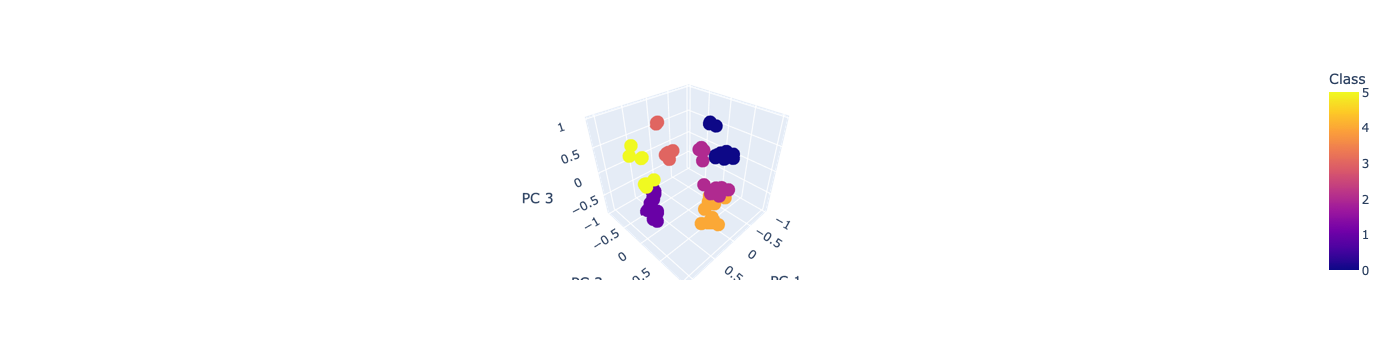

In [111]:
# Using  a 3D view to display the 3 PC's 
import plotly.express as px
fig = px.scatter_3d(clustered_df, x='PC 1', y='PC 2', z='PC 3',
              color='Class',
              hover_name='CoinName'
              )

fig.show()

In [112]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(
    x='TotalCoinsMined',
    y='MaxSupply',
    by='Class' ,
    hover_cols=["CoinName"]
)

:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (MaxSupply,CoinName)

#### Table of Tradable Cryptocurrencies

In [106]:
# Table with tradable cryptos
clustered_df.hvplot.table(["CoinName", "Algorithm", "ProofType", "MaxSupply", "TotalCoinsMined", "Class"])

:Table   [CoinName,Algorithm,ProofType,MaxSupply,TotalCoinsMined,Class]

In [113]:
# Print the total number of tradable cryptocurrencies
num_tradable_coins = clustered_df['CoinName'].count()
print(f'The Number of tradable coins as per the analysis is {num_tradable_coins}')

The Number of tradable coins as per the analysis is 136
